In [69]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from enum import Enum

In [61]:
def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

## Player Classes

### Base Player class
This is to be inherited and treated as a virtual class

In [142]:
AGENT_VERBOSE = True
class BasePlayer:
    def __init__(self,player_symbol) -> None:
        self.player_symbol = player_symbol
        self.num_rows = 0
        self.num_cols = 0
    def choose_action(self,valid_actions=None,board=None):
        raise NotImplementedError("Player class is virtual, please inherent from it")
    def give_reward(self,reward):
        raise NotImplementedError("Player class is virtual, please inherent from it")
    def reset(self):
        raise NotImplementedError("Player class is virtual, please inherent from it")
    


### Random Player

In [133]:
class RandomPlayer(BasePlayer):
    def __init__(self, player_symbol) -> None:
        super().__init__(player_symbol)
    def choose_action(self, valid_actions=None, board=None):
        return np.random.choice(valid_actions)
    def give_reward(self, reward):
        pass
    def reset(self):
        pass

In [160]:
def get_next_board_state(board,action,player_symbol):
    try:
        col = board[:,action]
        idx = int(np.where(col == 0)[0][-1])
        col[idx] = player_symbol
        return board.copy()
    except:
        return None
def get_possible_moves(board):
    return [i for i,j in enumerate(board[0]) if j == 0]

In [246]:
class ACTION_REASONING(Enum):
    RANDOM = 1
    POLICY = 2

class QPlayer(BasePlayer):
    def __init__(self, player_symbol,epsilon = 0.5,prop_factor=0.5,alpha=0.4) -> None:
        super().__init__(player_symbol)
        self.initial_epsilon = epsilon
        self.epsilon = epsilon
        self.action_history = []
        self.action_reasoning = []
        self.board_history = []
        self.alpha = alpha
        self.prop_factor = prop_factor
        self.q_table = {}
    def get_board_hash(self,board):
        return str(board.flatten())
    def choose_action(self, valid_actions=None, board=None):
        action = None
        
        if np.random.random() < self.epsilon:
            action = np.random.choice(valid_actions)
            self.action_history.append(action)
            self.action_reasoning.append(ACTION_REASONING.RANDOM)
            self.board_history.append(board.copy())
        else:
            st_reward = self.q_table.get(self.get_board_hash(board),None)
            if st_reward:
                st_reward = np.array([v if i in valid_actions else - 999.0 for i,v in  enumerate(st_reward)]) #Force agent to not make invalid actions
                tmp = max(st_reward)

                action = np.random.choice(np.where(st_reward == max(st_reward))[0]) #Choose a random action from all actions that have the highest q values
                self.action_history.append(action)
                self.action_reasoning.append(ACTION_REASONING.POLICY)
                self.board_history.append(board.copy())

            else:
                action = np.random.choice(valid_actions)
                self.action_history.append(action)
                self.action_reasoning.append(ACTION_REASONING.POLICY)
                self.board_history.append(board.copy())

        return action
    def reset(self):
        self.epsilon = self.initial_epsilon
        self.action_history = []
        self.action_reasoning = []
        self.board_history = []
    
    def get_transition_probabilities(self,board,how='random'):
        if how.lower() == 'rand' or how.lower() == 'random':
            mvs = get_possible_moves(board)
            return [(get_next_board_state(board,m,self.player_symbol * -1),1.0/len(mvs)) for m in mvs]
        elif how.lower() == 'q':
            raise NotImplementedError("Did not implement q transition probs yet")


    def give_reward(self, reward):
        for i,(action,reason,board) in enumerate(zip(reversed(self.action_history),reversed(self.action_reasoning),reversed(self.board_history))): #Iterate over all action,board,reasons backwards from start
            # if reason == ACTION_REASONING.RANDOM:
            #     pass
            #     i = i -1
            #     break

            st_reward = self.q_table.get(self.get_board_hash(board))
            if st_reward:
                _board = board.copy()
                _board = get_next_board_state(board,action,self.player_symbol)
                transition_probs = self.get_transition_probabilities(_board,how='rand')
                # self.q_table[self.get_board_hash(board)] = []
                q_updates = []
                for s_prime,prob in transition_probs:
                    max_q = np.max(self.q_table.get(self.get_board_hash(s_prime),[0]))
                    q_updates.append((max_q * self.alpha + reward * np.power(self.prop_factor,i)) * prob)
                new_q = np.sum(q_updates)
                # self.q_table.get(self.get_board_hash)
                st_reward[action] = new_q

            else:
                self.q_table[self.get_board_hash(board)] = [reward * np.power(self.prop_factor,i) if j == action else 0.0 for j in range(self.num_cols)]
            ############################### OLD ##################################
            # st_reward = self.q_table.get(self.get_board_hash(board))
            # if st_reward:
            #     next_attpt = get_next_board_state(board,action,player_symbol=self.player_symbol)
            #     next_reward = self.q_table.get(self.get_board_hash(next_attpt),None) if next_attpt is not None else None
            #     if next_reward:
            #         st_reward[action] = st_reward[action] * (1-self.alpha) + (self.alpha * max(next_reward) * reward)
            #     else:
            #         st_reward[action] = st_reward[action] * (1-self.alpha) + reward * self.alpha
            # else:
            #     self.q_table[self.get_board_hash(board)] = [reward * np.power(self.prop_factor,i) if j == action else 0 for j in range(self.num_cols)]






In [203]:
a = np.array([1,2,3,4,3])
np.where(a == max(a))

(array([3]),)

In [124]:
tmp = np.array([0.9,0.9,0.7,0.5])
np.argmax(tmp)
np.where(tmp == max(tmp))[0]

array([0, 1])

## Board Class

In [285]:
class Board:
    def __init__(self,p1:BasePlayer,p2:BasePlayer,num_rows=7,num_cols=7):
        self.num_rows= num_rows
        self.num_cols = num_cols
        self.p1 = p1
        self.p2 = p2
        self.p1.num_rows = num_rows
        self.p1.num_cols = num_cols
        self.p2.num_rows = num_rows
        self.p2.num_cols = num_cols
        self.board = np.zeros(shape=(num_rows,num_cols),dtype=int)
    def check_win(self):
        
        if(len(self.get_valid_moves()) == 0): return None
        horizontal_kernel = np.array([[ 1, 1, 1, 1]])
        vertical_kernel = np.transpose(horizontal_kernel)
        diag1_kernel = np.eye(4, dtype=np.uint8)
        diag2_kernel = np.fliplr(diag1_kernel)
        detection_kernels = [horizontal_kernel, vertical_kernel, diag1_kernel, diag2_kernel]
        for kernel in detection_kernels:

            a = convolve2d(self.board,kernel,mode='valid')
            if( (a == 4).any()):
                return 1
            if ((a == -4).any()):
                return -1
            
            # print(a.any())
        return 0
    def get_valid_moves(self):
        return [i for i,j in enumerate(self.board[0]) if j == 0]
    def reset(self):
        self.board = np.zeros(shape=(self.num_rows,self.num_cols))
    def __str__(self) -> str:
        visualize(self.board)
        return ""
    def place(self,move,player_symbol=1):
        if move not in self.get_valid_moves():
            raise RuntimeError(f"Invalid Action {move} with board state: \n{str(self.board)}")
        col = self.board[:,move]
        idx = int(np.where(col == 0)[0][-1])
        col[idx] = player_symbol
    def play_agents(self,verbose=True):
        
        while self.check_win() == 0 and self.check_win() is not None:
            valid_actions = self.get_valid_moves()
            if verbose == 2 and isinstance(self.p1,QPlayer):
                print(self.p1.q_table[self.p1.get_board_hash(self.board)])
            p1_action = self.p1.choose_action(valid_actions=valid_actions,board=self.board)
            self.place(p1_action,player_symbol=self.p1.player_symbol)
            if verbose:
                print(self)
            if self.check_win() == self.p1.player_symbol:
                if verbose:
                    print(f"Player {self.p1.player_symbol} Wins!")
                return self.p1.player_symbol
            elif self.check_win() is None:
                if verbose:
                    print("Tie!")
                    return None
            else:
                valid_actions = self.get_valid_moves()
                if verbose == 2 and isinstance(self.p2,QPlayer):
                    print(self.p2.q_table[self.p2.get_board_hash(self.board)])
                p2_action = self.p2.choose_action(valid_actions=valid_actions,board=self.board)
                self.place(p2_action,player_symbol=self.p2.player_symbol)

                if verbose:
                    print(self)

                if self.check_win() == self.p2.player_symbol:
                    if verbose:
                        print(f"Player {self.p2.player_symbol} Wins!")
                    return self.p2.player_symbol

        return self.check_win()
    def train_agents(self, n_iterations=500):
        for i in range(n_iterations):
            if i % 1000 == 0:
                print(f'Iteration {i}')
            winner = self.play_agents(verbose=False)
            if winner is None:
                self.p1.give_reward(0.5)
                self.p2.give_reward(0.5)
            elif winner == self.p1.player_symbol:
                self.p1.give_reward(1.0)
                self.p2.give_reward(-1.0)
            elif winner == self.p2.player_symbol:
                self.p2.give_reward(1.0)
                self.p1.give_reward(-1.0)
            
            self.p1.reset()
            self.p2.reset()
            self.reset()

        

In [286]:
q1 = QPlayer(player_symbol=1)
q2 = QPlayer(player_symbol=-1)

b = Board(q1,q2,num_rows=4,num_cols=4)

In [287]:
b.train_agents(n_iterations=50000)


Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Iteration 20000
Iteration 21000
Iteration 22000
Iteration 23000
Iteration 24000
Iteration 25000
Iteration 26000
Iteration 27000
Iteration 28000
Iteration 29000
Iteration 30000
Iteration 31000
Iteration 32000
Iteration 33000
Iteration 34000
Iteration 35000
Iteration 36000
Iteration 37000
Iteration 38000
Iteration 39000
Iteration 40000
Iteration 41000
Iteration 42000
Iteration 43000
Iteration 44000
Iteration 45000
Iteration 46000
Iteration 47000
Iteration 48000
Iteration 49000


In [293]:
winners = []

r1 = RandomPlayer(player_symbol=-1)
b2 = Board(q1,q2,num_rows=4,num_cols=4)
for i in range(500):
    q1.epsilon = 0.0
    q2.epsilon = 0.0
    winners.append(b2.play_agents(verbose=False))
    b2.reset()
    q1.reset()
    q2.reset()

winners = [i if i is not None else 0 for i in winners]
print(np.unique(winners,return_counts=True))
    


(array([0, 1]), array([  1, 499]))


In [150]:
# print(winners)

In [289]:
q1.q_table

{'[-1  0 -1  1 -1  0  1  1 -1 -1  1  1  1  1 -1 -1]': [0.0, 0.5, 0.0, 0.0],
 '[ 0  0 -1  0 -1  0  1  1 -1 -1  1  1  1  1 -1 -1]': [0.0, 0.0, 0.0, 0.25],
 '[ 0  0  0  0 -1  0  0  1 -1 -1  1  1  1  1 -1 -1]': [0.0, 0.0, 0.125, 0.0],
 '[ 0  0  0  0 -1  0  0  0 -1  0  1  1  1  1 -1 -1]': [0.0, 0.0, 0.0, 0.0625],
 '[ 0  0  0  0  0  0  0  0 -1  0  1  0  1  1 -1 -1]': [0.0, 0.0, 0.0, 0.03125],
 '[ 0  0  0  0  0  0  0  0 -1  0  1  0  1  0 -1  0]': [0.0,
  0.015625,
  0.0,
  0.0],
 '[ 0  0  0  0  0  0  0  0  0  0  0  0  1  0 -1  0]': [0.0,
  0.0,
  0.0078125,
  0.0],
 '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]': [0.00390625, 0.0, 0.0, 0.0],
 '[ 1.  0. -1.  1. -1.  0.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.]': [0.0,
  1.0,
  0.0,
  0.0],
 '[ 1.  0. -1.  0. -1.  0.  1. -1.  1.  0.  1. -1. -1.  1. -1.  1.]': [0.0,
  0.0,
  0.0,
  0.5],
 '[ 0.  0. -1.  0. -1.  0.  1.  0.  1.  0.  1. -1. -1.  1. -1.  1.]': [0.35,
  0.19166666666666665,
  0.0,
  0.17166666666666666],
 '[ 0.  0. -1.  0.  0.  0.  1.  0.  0.  0

[0.0175625, 0.0050145277777777775, 0.13219583333333335, 0.007729722222222223]


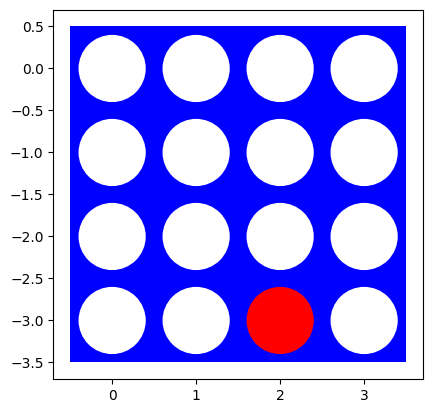


[-0.06139791666666666, 0.007820833333333334, 0.005008333333333333, -0.24876138888888888]


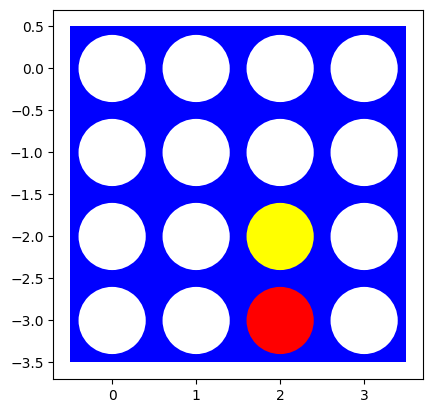


[0.030312500000000003, -0.0049374999999999974, 0.009828166666666667, 0.011668055555555555]


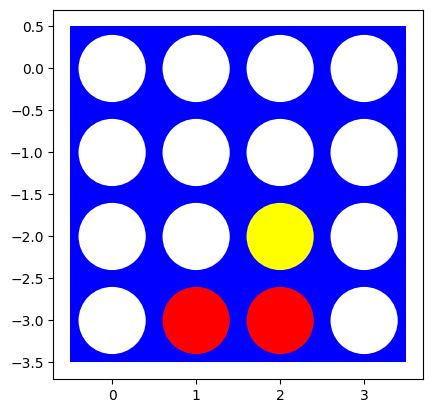


[0.020395833333333335, -0.4980391666666667, -0.49224999999999997, 0.06225]


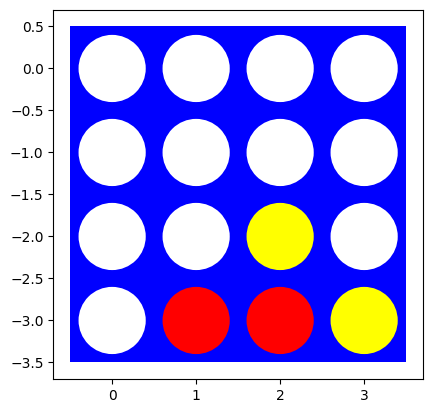


[0.019625, -0.049375, -0.056874999999999995, 0.02125]


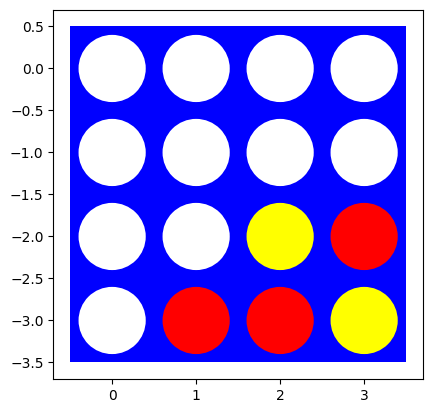


[0.031469444444444446, 0.031625, 0.02175, 0.02125]


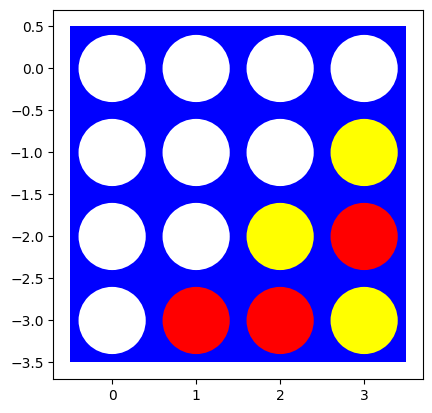


[0.03945, 0.05625, 0.03908333333333333, -0.11355555555555555]


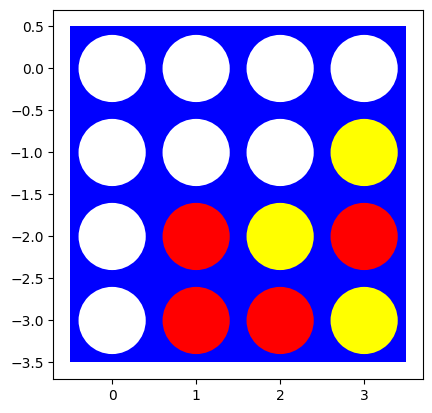


[0.0, -0.22333333333333333, 0.0, 0.041805555555555554]


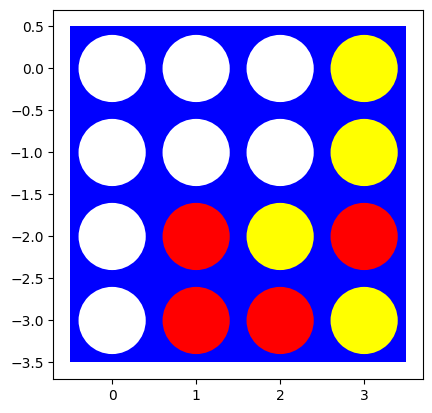


[0.14694444444444446, 0.0, 0.08361111111111111, 0.0]


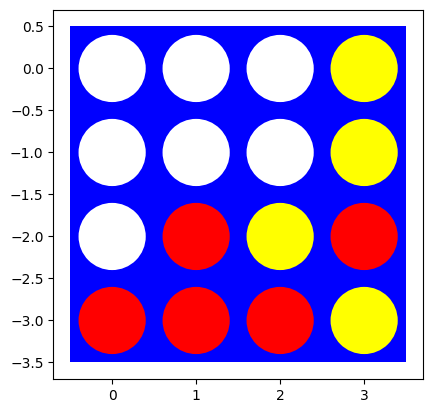


[-0.4788888888888888, 0.0, 0.07916666666666666, 0.0]


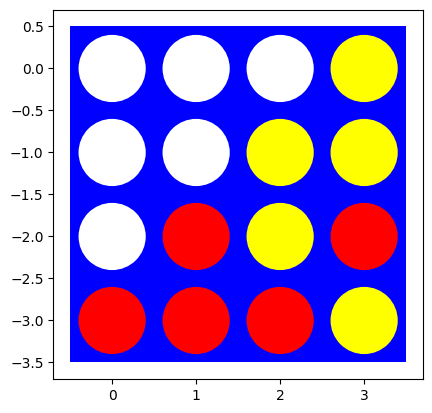


[0.125, 0.0, 0.0, 0.0]


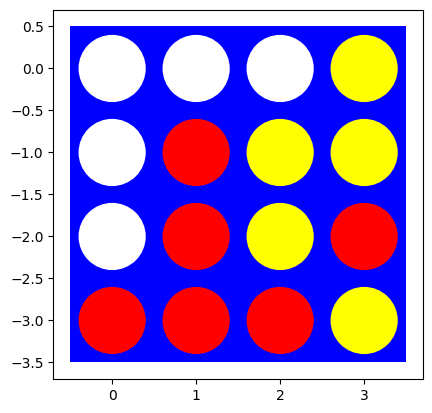

KeyError: '[ 0.  0.  0. -1.  0.  1. -1. -1.  0.  1. -1.  1.  1.  1.  1. -1.]'

In [297]:
q1.reset()
q2.reset()
q1.epsilon = 0.5
q2.epsilon = 0.5
b2.reset()
b2.play_agents(verbose=2)